## A/B-тестирование

Этапы A/B-тестирования:
* **Определение метрик и выдвижение гипотезы;** \
    Например: *Аналитики провели некоторое исследование и составили следующую гипотезу: «При внедрении персональных предложений вовлечённость пользователей увеличится на 10 %»*;
* **Подготовка к тестированию**:
    + Определение размера выборки и длительности теста:
        - [калькулятор размера выборки Эвана Миллера](https://www.evanmiller.org/ab-testing/sample-size.html);
        - [rалькулятор длительности теста VWO](https://vwo.com/tools/ab-test-duration-calculator/);
    + Принятие решения о целесообразности проведения тестирования (хватит ли ресурсов, окупится ли внедрение);
    + Разработка варианта B;
* Настройка распределения на группы;
* Проверка корректности эксперимента: \
    Нет изменений внешних факторов, резких необоснованных скачков, данные потупают в систему и т.п;
* Сбор результатов;
* Анализ результатов;
* Формулирование выводов и принятие решения;

Принципы:
* Исключить влияние извне;
* Данных должно быть много;
* Правильный инструмент анализа;

Этап анализа результатов и формирования выводов:
* подготовить данные к анализу и убедиться, что соблюдены принципы A/B-тестирования (в каждой группе собрано достаточно данных и длительность теста одинакова, группы сбалансированы и отсутствуют пересечения в группах);
* визуально оценить интересующие метрики в каждой из групп, чтобы сделать первичные выводы;
* убедиться в том, что метрики стабилизированы и можно проводить статистические тесты (проблема подглядывания). Для этого чаще всего используются кумулятивные метрики (метрика считается стабилизированной во времени, если её кумулятивный вариант переходит в прямую на графике);
* если метрика стабилизировалась, то можно проводить статистические тесты, которые позволяют проверить гипотезу о равенстве показателей в группах при альтернативных гипотезах (неравенство/больше/меньше), но предварительно необходимо узнать распределение показателя, который пытаемся сравнить (помним о том, что каждый тест имеет свою область применения);
* в комплексе со статистическими тестами можно использовать доверительные интервалы для параметра, чтобы оценить его возможные границы;
* на основе результатов статистических тестов и построенных доверительных интервалов мы формируем вывод и принимаем решение.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [5]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [6]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

In [7]:
ab_data_grouped = ab_data.groupby(['timestamp','group'], as_index=False).agg({'user_id': 'count', 'converted': 'sum'}).rename(columns={'user_id': 'users_count'})
ab_data_grouped['conversion'] = round(ab_data_grouped['converted']*100/ab_data_grouped['users_count'], 2)
ab_data_grouped.head()

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.52
1,2017-01-02,B,2848,339,11.90
2,2017-01-03,A,6584,749,11.38
3,2017-01-03,B,6620,754,11.39
4,2017-01-04,A,6573,797,12.13


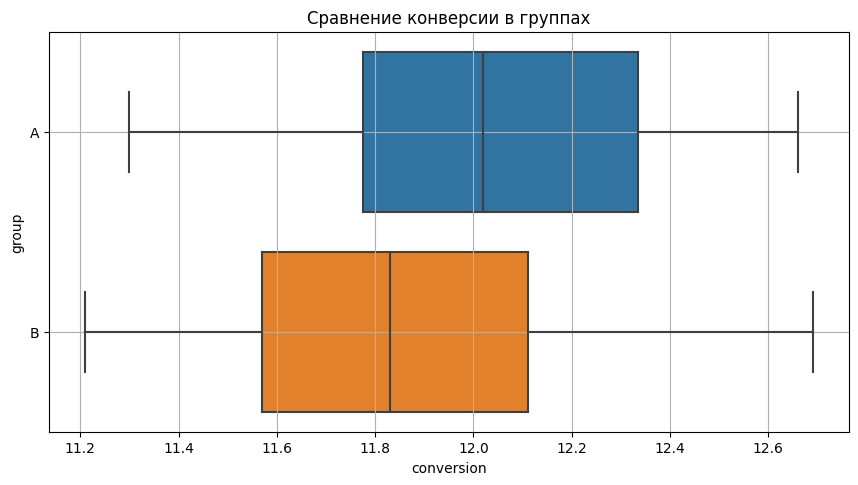

In [8]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=ab_data_grouped, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

Медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Разброс конверсии в группе B несколько больше, чем в группе A, т.е. в группе А показатели более стабильны.

In [9]:
conversion_piv = ab_data_grouped.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.033478,12.02
B,11.872174,11.83


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают (т.е. выбросы не сильно влияют или отсутствуют). При этом разница между показателями в группах менее 0.3%

Стабилен ли показатель конверсии в группах во времени или он колеблется? 
Прогонять результаты через статистические тесты можно только после того, как убедимся, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания.

**Кумулятивная метрика** — это отображение целевой метрики, когда отслеживаем её поведение за каждый день — накопленным итогом по дням.

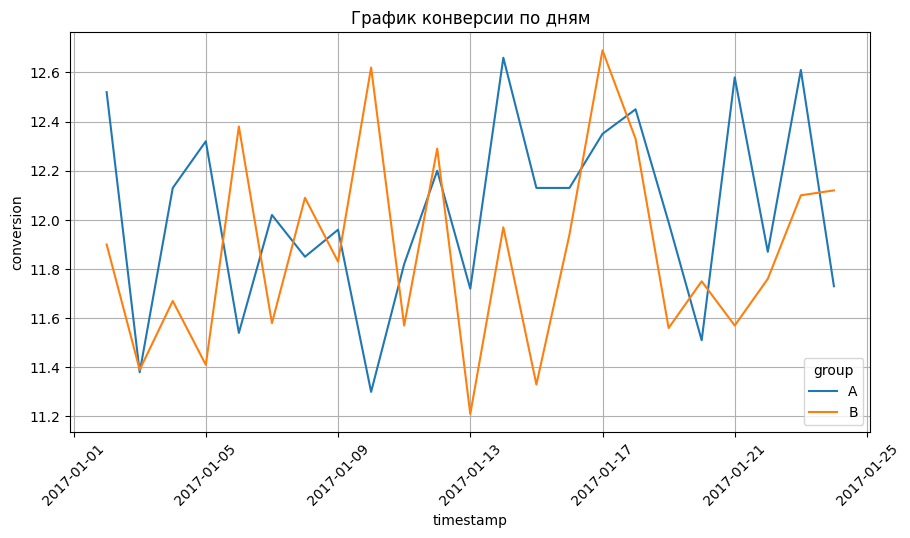

In [10]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=ab_data_grouped,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Конверсия у обеих групп «скачет» день ото дня

In [11]:
# вычисляем кумулятивную сумму количества посетителей
ab_data_grouped['cum_users_count'] = ab_data_grouped.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
ab_data_grouped['cum_converted'] = ab_data_grouped.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
ab_data_grouped['cum_conversion'] = ab_data_grouped['cum_converted']/ab_data_grouped['cum_users_count'] * 100
display(ab_data_grouped.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.52,2851,357,12.521922
1,2017-01-02,B,2848,339,11.90,2848,339,11.903090
2,2017-01-03,A,6584,749,11.38,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.39,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.13,16008,1903,11.887806


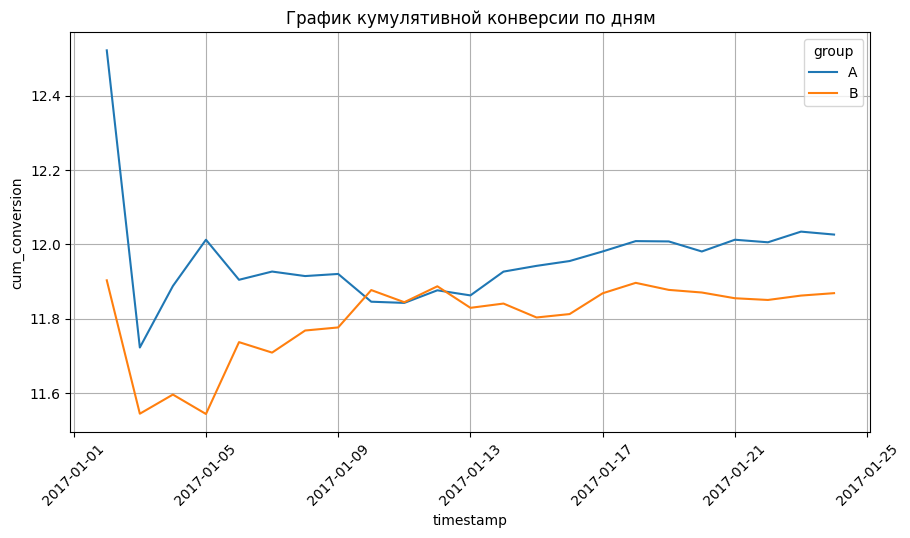

In [12]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=ab_data_grouped, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

До 2017-01-09 конверсия была нестабильна, но после 2017-01-11 резкие скачки прекратились. Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

### Статистический тест для конверсии

Признак того, осуществлена конверсия пользователя или нет — это случайная величина, имеющая распределение Бернулли, она имеет два возможных исхода. Вероятность успеха: $p$, вероятность неуспеха: $q = 1 - p$

Для проверки гипотезы равенства пропорций мы можем воспользоваться уже знакомым нам z-критерием для пропорций. Этот критерий является наиболее популярным для задачи определения статистической значимости изменения конверсии.

In [13]:
from statsmodels.stats.proportion import proportions_ztest

converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


Нулевая гипотеза: \
$H_0 : p_a = p_b$, то есть конверсии в группах А и B равны.

Альтернативная гипотеза: \
$H_1 : p_a > p_b$, то есть конверсия в группе А выше, чем конверсия в группе B.

In [14]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике в группах статистически не значима. 

На основе этого вывода мы принимаем решение о том, что делать дальше. Возможные варианты:

* отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить использование текущей версии рекомендаций;
* попытаться усовершенствовать модель и провести тестирование снова;
* использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

### Статистические тесты для других метрик

Помимо конверсии, нужно рассматривать и другие метрики, например средний чек. Возможно же такое, что конверсия в группах одинаковая, а вот средние чеки существенно различаются.

Перед тем как проводить статистический тест, важно узнать распределение метрики.

Например, время, проведённое на сайте, часто распределено нормально, и тогда мы можем использовать T-тест для средних.

А вот денежные метрики, такие как средний чек, часто напоминают логнормальное распределение.

#### Пример

Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательная для наших посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 5 %.

In [15]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


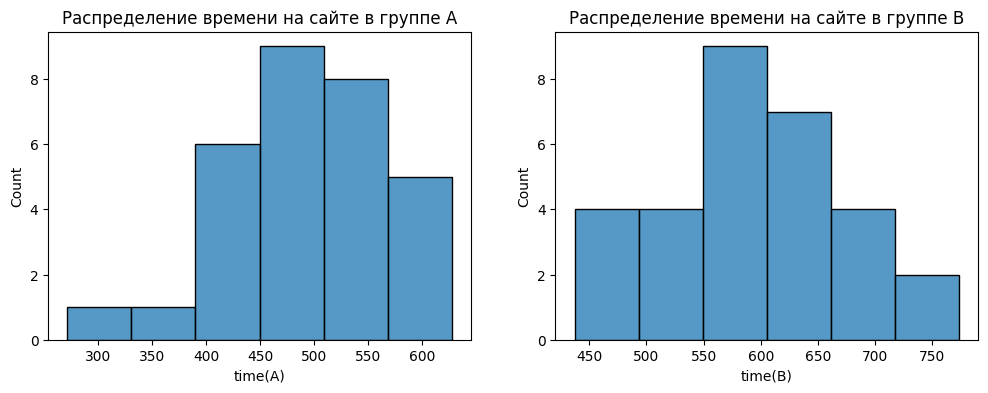

In [16]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

In [17]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Нулевая гипотеза: \
$H_0 : p_a = p_b$, то есть среднее время в группах А и B одинаково.

Альтернативная гипотеза: \
$H_1 : p_a < p_b$, то есть среднее время в группе А меньше, чем в группе B.

In [18]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


Тёмная тема более привлекательна для наших посетителей, чем светлая